In [1]:
# Used lots of code from this kernel https://www.kaggle.com/lgreig/simple-lgbm-baseline

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.parquet
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.feather
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.h5
/kaggle/input/riiid-train-data-multiple-formats/riiid_train.jay
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
# Used most of coding from this kernel https://www.kaggle.com/lgreig/simple-lgbm-baseline

import riiideducation
import dask.dataframe as dd
import  pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
train = pd.read_pickle("../input/riiid-train-data-multiple-formats/riiid_train.pkl.gzip")
train = train[train.content_type_id == False]
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')
#arrange by timestamp

In [3]:
train = train.sort_values(['timestamp'], ascending=True)

train.drop(['timestamp','content_type_id'], axis=1,   inplace=True)

results_c = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c.columns = ["answered_correctly_content"]

results_u = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum'])
results_u.columns = ["answered_correctly_user", 'sum']

In [4]:
train

,row_id,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,1,3,1,NaN,<NA>
84775752,84775752,1805962620,5547,0,1,0,NaN,<NA>
94914466,94914466,2015251289,4024,0,0,1,NaN,<NA>
40818521,40818521,867941388,6659,0,3,1,NaN,<NA>
40821293,40821293,867946278,3977,0,2,1,NaN,<NA>
...,...,...,...,...,...,...,...,...
29310942,29310942,626308830,8185,9217,2,0,13000.0,True
29310943,29310943,626308830,6686,9218,0,0,10000.0,True
29310944,29310944,626308830,5860,9219,2,1,21000.0,True
29310945,29310945,626308830,11465,9220,0,0,25000.0,True


In [10]:
#train=train[train.answered_correctly!= -1 ]
print(train.content_id.nunique(), train.content_id.max())

13523 13522


In [11]:
questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv',
                            usecols=[0,1, 3,4],
                            dtype={'question_id': 'int16',
                              'part': 'int8','bundle_id': 'int16','tags': 'str'}
                          )
tag = questions_df["tags"].str.split(" ", n = 10, expand = True) 
#reading in question df
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']

questions_df =  pd.concat([questions_df,tag],axis=1)
questions_df['tags1'] = pd.to_numeric(questions_df['tags1'], errors='coerce')
questions_df['tags2'] = pd.to_numeric(questions_df['tags2'], errors='coerce')
questions_df['tags3'] = pd.to_numeric(questions_df['tags3'], errors='coerce')
questions_df['tags4'] = pd.to_numeric(questions_df['tags4'], errors='coerce')
questions_df['tags5'] = pd.to_numeric(questions_df['tags5'], errors='coerce')
questions_df['tags6'] = pd.to_numeric(questions_df['tags6'], errors='coerce')

In [ ]:
questions_df

In [12]:
X = train.iloc[90000000:,:]
X['prior_question_had_explanation'].fillna(False, inplace=True)
X = pd.merge(X, results_u, on=['user_id'], how="left")
X = pd.merge(X, results_c, on=['content_id'], how="left")
X = pd.merge(X, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

X=X[X.answered_correctly!= -1 ]
X=X.sort_values(['user_id'])
Y = X[["answered_correctly"]]
X = X.drop(["answered_correctly"], axis=1)
X

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,row_id,user_id,content_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,answered_correctly_content,question_id,bundle_id,part,tags,tags1,tags2,tags3,tags4,tags5,tags6
1119023,14123,138650,4931,804,1,16000.0,True,0.713628,775.0,0.426790,4931,4931,5,8,8.0,NaN,NaN,NaN,NaN,NaN
1119056,14125,138650,9113,806,3,22000.0,True,0.713628,775.0,0.430757,9113,9113,5,73,73.0,NaN,NaN,NaN,NaN,NaN
1119070,14126,138650,4079,807,2,27000.0,True,0.713628,775.0,0.421442,4079,4079,5,73,73.0,NaN,NaN,NaN,NaN,NaN
1119081,14127,138650,5000,808,0,14000.0,True,0.713628,775.0,0.469838,5000,5000,5,26,26.0,NaN,NaN,NaN,NaN,NaN
1119089,14128,138650,3609,809,0,8000.0,True,0.713628,775.0,0.752486,3609,3609,5,85,85.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979775,101224085,2147382115,10684,23,0,22000.0,True,0.600000,18.0,0.862979,10684,10684,2,62 137 142 92 29,62.0,137.0,142.0,92.0,29.0,NaN
1980222,101224091,2147382115,587,29,3,16000.0,True,0.600000,18.0,0.306000,587,587,2,143 30 81 92,143.0,30.0,81.0,92.0,NaN,NaN
1979553,101224082,2147382115,1291,20,3,37000.0,True,0.600000,18.0,0.715133,1291,1291,2,143 176 38 102,143.0,176.0,38.0,102.0,NaN,NaN
1979906,101224088,2147382115,611,26,1,18000.0,True,0.600000,18.0,0.676595,611,611,2,2 107 38 92,2.0,107.0,38.0,92.0,NaN,NaN


In [13]:
import gc
del train
gc.collect()

32

In [14]:
categorical_X = X[['tags1','tags2','tags3', 'tags4', 'tags5']]
questions_X = X[["content_id"]]
continuous_X = X[['part', 'answered_correctly_user', 'answered_correctly_content', 'sum', 'prior_question_elapsed_time','prior_question_had_explanation']]
print(Y.shape, categorical_X.shape, continuous_X.shape)
del X
gc.collect()

(9271300, 1) (9271300, 5) (9271300, 6)


20

In [29]:
questions_X.dtypes

content_id    int16
dtype: object

In [ ]:
categorical_X.max()

### Our categorical variables are bundle_id, part, and tags1-5.  We need to embed these, and also make all the continous columns have mean 0 and std 1 to make training the network easier

In [15]:
import tensorflow as tf

In [16]:
categorical_X.fillna(0, inplace=True)
categorical_X.isna().sum()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


tags1    0
tags2    0
tags3    0
tags4    0
tags5    0
dtype: int64

In [17]:
mean = continuous_X.mean()
std = continuous_X.std()
continuous_X = (continuous_X-continuous_X.mean())/continuous_X.std()

In [18]:
continuous_X.pop("part")

1119023    0.514026
1119056    0.514026
1119070    0.514026
1119081    0.514026
1119089    0.514026
             ...   
1979775   -1.295288
1980222   -1.295288
1979553   -1.295288
1979906   -1.295288
1979667   -1.295288
Name: part, Length: 9271300, dtype: float64

In [19]:
categorical_X = categorical_X[["tags1", "tags2"]]

In [33]:
# define two sets of inputs
inputCategorical = tf.keras.Input(shape=(2,))
inputContinuous = tf.keras.Input(shape=(5,))
inputQuestions = tf.keras.Input(shape=(1,))
# embbed the categorical variables
x = tf.keras.layers.Embedding(input_length=2, input_dim=188, output_dim=8)(inputCategorical)
x = tf.keras.layers.Reshape(target_shape=(16,))(x)
cat_x = tf.keras.Model(inputs=inputCategorical, outputs=x)

# the second branch opreates on the second input
y = tf.keras.layers.Dense(32, activation="relu")(inputContinuous)
y = tf.keras.Model(inputs=inputContinuous, outputs=y)

d = tf.keras.layers.Embedding(input_length=1, input_dim=13524, output_dim=50)(inputQuestions)
d = tf.keras.layers.Reshape(target_shape=(50,))(d)
cat_d = tf.keras.Model(inputs=inputQuestions, outputs=d)

# combine the output of the two branches
print("here")
combined = tf.keras.layers.Concatenate()([cat_d.output, cat_x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = tf.keras.layers.Dropout(.2)(combined)
z = tf.keras.layers.Dense(1, activation="sigmoid")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = tf.keras.Model(inputs=[cat_d.input, cat_x.input, y.input], outputs=z)

here


In [34]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy', 'AUC'])

In [22]:
Y = Y.values.reshape(-1)
Y.shape

(9271300,)

In [35]:
gc.collect()

3509

In [36]:
history = model.fit(x=[questions_X, categorical_X, continuous_X], y=Y, validation_split=.2, shuffle=False, verbose=1, epochs=3)

Epoch 1/3
231783/231783 [==============================] - 2198s 9ms/step - loss: 0.5319 - accuracy: 0.7310 - auc: 0.7569 - val_loss: 0.5378 - val_accuracy: 0.7244 - val_auc: 0.7540
Epoch 2/3
231783/231783 [==============================] - 2130s 9ms/step - loss: 0.5281 - accuracy: 0.7332 - auc: 0.7617 - val_loss: 0.5384 - val_accuracy: 0.7239 - val_auc: 0.7525
Epoch 3/3
231783/231783 [==============================] - 2116s 9ms/step - loss: 0.5255 - accuracy: 0.7349 - auc: 0.7650 - val_loss: 0.5394 - val_accuracy: 0.7234 - val_auc: 0.7505


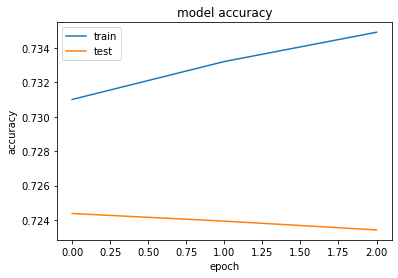

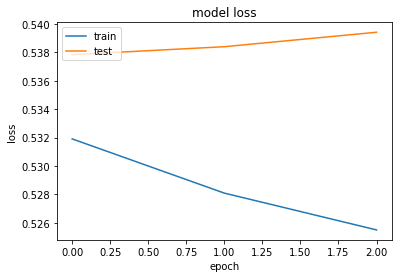

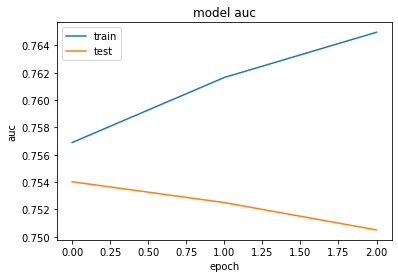

In [37]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()